## FSL FEAT in nipype

In [5]:
import os

import nipype
import nipype.interfaces.io as nio
import nipype.interfaces.fsl as fsl
import nipype.interfaces.ants as ants
import nipype.pipeline.engine as pe
import nipype.interfaces.utility as util
import nipype.algorithms.modelgen as model

In [6]:
import glob
subject_ids = [x.split('/')[-3].split('-')[1] for x in sorted(glob.glob('../derivatives/glm_nilearn/subject_level_model/sub-*/ses-rlsat/'))]
len(subject_ids)

37

In [7]:
# general set-up
project_folder = '/home/Public/trondheim'
work_dir = os.path.join(project_folder, 'processing', 'nipype_workflow_folders')

t_r = 1.38
hpcutoff = 10000.   # set very high - don't highpass filter; we use cosines in the DM instead

# task-specific part for rl-sat
spaces = ['T1w']   # shouldn't touch this but just in case we _do_ want to go back to MNI....
smoothing_fwhm = ['1p5'] #, '4p5']
model_n = ['1-dm-RTdur']
ses = 'rlsat'      # don't make this a list, that won't work
task = 'rlsat'     # don't make this a list, that won't work

template_brain = '/home/Public/trondheim/sourcedata/templates/mni_icbm152_t1_tal_nlin_asym_09c_brain.nii'

## First & Second level models

In [8]:
def get_session_info(subject_id, run, task='rlsat', ses='rlsat', space='T1w', shift=-1.38/2, model_n='0', smoothing_fwhm='1p5',
                    root_dir='/home/Public/trondheim', include_physio=True):
    # other space: MNI152NLin2009cAsym
    import pandas as pd
    import numpy as np
    import os
    from nipype.interfaces.base import Bunch

    if task == 'rlsat':
        def merge_events_regressors(events, regressors, 
                                    on_stimulus=('value_chosen', 'value_unchosen', 'value_high', 'value_low', 'outcome', 'value_difference'),
                                    on_feedback=('value_chosen', 'outcome'),
                                    zscore=(),
                                    demean=(), rescale_values=False):
            ''' merge 'events' df (with onsets trial types) with trial-wise 'regressors' df, which contains the covariates '''
            ''' what to do with demeaning'''

            # Put values on same scale as outcome?
            if rescale_values:
                max_value = regressors[['value_high', 'value_low']].max().max()
                regressors['value_high'] /= max_value
                regressors['value_low'] /= max_value
                regressors['value_chosen'] /= max_value
                regressors['value_unchosen'] /= max_value

            if 'rt' in on_stimulus:
                # extract response time from events, add to trial-wise regressors
                tmp = events.pivot_table(values='onset', index='trial_nr', columns='trial_type')
                tmp['response_onset'] = tmp[['response_left', 'response_right']].apply(lambda x: np.nansum(x), axis=1)
                tmp.loc[(pd.isnull(tmp.response_left) & pd.isnull(tmp.response_right)), 'response_onset'] = np.nan
                tmp['rt'] = tmp['response_onset'] - tmp['stimulus']
                regressors = pd.merge(regressors, tmp.reset_index()[['trial_nr', 'rt']], how='outer')
            if 'value_difference' in on_stimulus:
                regressors['value_difference'] = regressors['Q_value_difference'] #regressors['SR.r2'] - regressors['SR.r1']


            # z-score regressors that need to be z-scored
            if len(zscore)>0:
                for regressor_name in zscore:
                    regressors[[regressor_name]] = regressors[[regressor_name]].apply(lambda x: (x-x.mean())/x.std())

            if len(demean)>0:
                for regressor_name in demean:
                    regressors[[regressor_name]] = regressors[[regressor_name]].apply(lambda x: (x-x.mean()))
            ## 
            if len(on_stimulus) > 0:
                regressors_on_stimulus = regressors.melt(id_vars='trial_nr', 
                                                         value_vars=on_stimulus).rename(columns={'variable':'trial_type', 'value': 'modulation'})
                regressors_on_stimulus['trial_type2'] = 'stimulus'

            if len(on_feedback) > 0:
                regressors_on_feedback = regressors.melt(id_vars='trial_nr', 
                                                         value_vars=on_feedback).rename(columns={'variable':'trial_type', 'value': 'modulation'})
                regressors_on_feedback['trial_type2'] = 'feedback'


            # merge with events
            to_concat = [events]
            if len(on_stimulus) > 0:
                tmp_stimulus_regressors = pd.merge(events, regressors_on_stimulus, left_on=['trial_nr', 'trial_type'], right_on=['trial_nr', 'trial_type2']).rename(columns={'trial_type_y':'trial_type'})
                tmp_stimulus_regressors['trial_type'] = tmp_stimulus_regressors['trial_type'].apply(lambda x: 'stimulus_'+x)
                to_concat.append(tmp_stimulus_regressors[['trial_nr', 'onset', 'trial_type', 'duration', 'modulation']])
            if len(on_feedback) > 0:
                tmp_feedback_regressors = pd.merge(events, regressors_on_feedback, left_on=['trial_nr', 'trial_type'], right_on=['trial_nr', 'trial_type2']).rename(columns={'trial_type_y':'trial_type'})
                tmp_feedback_regressors['trial_type'] = tmp_feedback_regressors['trial_type'].apply(lambda x: 'feedback_'+x)
                to_concat.append(tmp_feedback_regressors[['trial_nr', 'onset', 'trial_type', 'duration', 'modulation']])
                
            # Merge
            events = pd.concat(to_concat, axis=0)
            # RTdur
            if 'rt' in on_stimulus:
                events = events.loc[~((events.trial_type=='stimulus_rt') & pd.isnull(events.modulation))]
                events.loc[events.trial_type=='stimulus_rt', 'duration'] = events.loc[events.trial_type=='stimulus_rt','modulation']
                events.loc[events.trial_type=='stimulus_rt','modulation'] = 1
                # events = events.loc[~((events.trial_type=='stimulus_rt') & (events.duration == 1))]   # If duration equals exactly 1, then there was no RT recorded
                events.loc[events.trial_type!='stimulus_rt', 'duration'] = 0.001
            else:
                events['duration'] = 0.001
            
            events = events.sort_values('onset').reset_index(drop=True)

#            print(events)

#            events['duration'] = 0.001
            events = events.loc[~(events.trial_type.isin(list(on_stimulus)+list(on_feedback)) & pd.isnull(events.modulation))]    
            events['modulation'] = events['modulation'].fillna(1)
            return events
        
        def make_contrast_matrix(events, demean_contrasts=True):
            events.loc[events.trial_type == 'cue_SPD', 'modulation'] = 1
            events.loc[events.trial_type == 'cue_ACC', 'modulation'] = -1
            events.loc[events.trial_type.isin(['cue_SPD', 'cue_ACC']), 'trial_type'] = 'cue_SPDminACC'
            if demean_contrasts:
                idx = events.trial_type == 'cue_SPDminACC'
                events.loc[idx, 'modulation'] = events.loc[idx, 'modulation']-events.loc[idx, 'modulation'].mean()
            tmp = events.loc[events.trial_type == 'cue_SPDminACC'].copy()
            tmp['trial_type'] = 'cue'
            tmp['modulation'] = 1
            events = pd.concat([events, tmp]).sort_values(['onset'])

            #
            events.loc[events.trial_type == 'response_left', 'modulation'] = 1
            events.loc[events.trial_type == 'response_right', 'modulation'] = -1
            events.loc[events.trial_type.isin(['response_left', 'response_right']), 'trial_type'] = 'response_leftminright'
            if demean_contrasts:
                idx = events.trial_type == 'response_leftminright'
                events.loc[idx, 'modulation'] = events.loc[idx, 'modulation']-events.loc[idx, 'modulation'].mean()
            tmp = events.loc[events.trial_type == 'response_leftminright'].copy()
            tmp['trial_type'] = 'response'
            tmp['modulation'] = 1
            events = pd.concat([events, tmp]).sort_values(['onset'])

            events.loc[events.trial_type.isin(['cue', 'stimulus', 'response', 'feedback']), 'trial_type'] = 'cuestimrespfeedback'
            return events

        def make_events_this_model(events, regressors, model_n):
            ### Create events corresponding to this model's design matrix
            rescale_values = False

            if model_n == '0a':
                on_stimulus=('value_difference',)
                on_feedback=('PE',)
                zscore = ()
                demean = ()
            elif model_n == '0a-z':
                on_stimulus=('value_difference',)
                on_feedback=('PE',)
                zscore = ('value_difference', 'PE')
                demean = ()
            elif model_n == '1-dm':
                on_stimulus=('value_difference',)
                on_feedback=('PE',)
                demean = ('value_difference', 'PE')
                zscore = ()
            elif model_n == '1-dm-RTdur':
                on_stimulus=('value_difference', 'rt')
                on_feedback=('PE',)
                zscore = ()
                demean = ('value_difference', 'PE')
            elif model_n == '1-z':
                on_stimulus=('value_difference',)
                on_feedback=('PE',)
                zscore = ('value_difference', 'PE')
                demean = ()


            events = merge_events_regressors(events, regressors, on_stimulus=on_stimulus, on_feedback=on_feedback, 
                                             zscore=zscore, demean=demean, rescale_values=rescale_values)[['onset', 
                                                                                                           'trial_type', 'duration', 'modulation']]

            return events
        
        ### files ###
        sub = subject_id
        event_fn = f'{root_dir}/derivatives/event_files/sub-{sub}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-{task}_run-{run}_events.tsv'
        regressor_fn = f'{root_dir}/derivatives/behavior/sub-{sub}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-{task}_run-{run}_desc-model-regressors-emc2.tsv'
        func_fn =  f'{root_dir}/derivatives/susan_smoothed_func/sub-{sub}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-{task}_run-{run}_space-{space}_desc-preproc_bold_smoothed_fwhm-{smoothing_fwhm}.nii.gz'
        # func_fn = f'{root_dir}/derivatives/fmriprep/fmriprep/sub-{sub}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-{task}_run-{run}_space-{space}_desc-preproc_bold.nii.gz'
        confounds_fn = f'{root_dir}/derivatives/fmriprep/fmriprep/sub-{sub}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-{task}_run-{run}_desc-confounds_timeseries.tsv'

        events = pd.read_csv(event_fn, sep='\t', index_col=None)
        regressors  = pd.read_csv(regressor_fn, sep='\t')
        
        # Call function that makes the events, merges with trial-by-trial regressors/covariates
        events = make_events_this_model(events, regressors, model_n)
        events = make_contrast_matrix(events)

        # slice time correction, nb: shift should be a negative number for STC
        events['onset'] += shift  

        ### confounds ###
        confounds = pd.read_csv(confounds_fn, sep='\t')
        cosine_cols = [x for x in confounds.columns if 'cos' in x]
        include_confounds = ['trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z', 'dvars', 'framewise_displacement'] + cosine_cols
        confounds = confounds[include_confounds].fillna(method='bfill')

        # get retroicor
        if include_physio:
            retroicor_fn = f'{root_dir}/derivatives/retroicor/sub-{sub}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-{task}_run-{run}_desc-retroicor_regressors.tsv'
            if not os.path.exists(retroicor_fn):
                ## take first 20 aCompCor components
                print("No retroicor found, including 20 a_comp_cor components")
                a_comp_cor = pd.read_csv(confounds_fn, sep='\t')[['a_comp_cor_' + str(x).zfill(2) for x in range(20)]]
                confounds = pd.concat([confounds, a_comp_cor], axis=1)
            else:
                retroicor = pd.read_csv(retroicor_fn, sep='\t', header=None).iloc[:,:20]  ## 20 components in total
                retroicor.columns = ['cardiac_' + str(x) for x in range(6)] + ['respiratory_' + str(x) for x in range(8)] + ['respiratoryxcardiac_' + str(x) for x in range(4)] + ['HRV', 'RVT']
                confounds = pd.concat([confounds, retroicor], axis=1)

        # save the confounds that we actually include in the GLM to csv, no header or index
        confounds_fn = f'{root_dir}/derivatives/confounds/sub-{sub}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-{task}_run-{run}_desc-confounds_timeseries.txt'
        os.makedirs(os.path.dirname(confounds_fn), exist_ok=True)
        confounds.to_csv(confounds_fn, sep='\t', header=False, index=False)

        ### Make bunch ###
        if model_n == '0a-z':
            conditions = ['cue_SPD',
                          'cue_ACC',
                          'stimulus',
                          'stimulus_value_difference',
                          'feedback',
                          'feedback_PE',
                          'response_left',
                          'response_right']
        elif model_n == '1-dm':
            conditions = ['cuestimrespfeedback',
                          'response_leftminright',
                          'cue_SPDminACC',
                          'stimulus_value_difference',
                          'feedback_PE']
        elif model_n == '1-dm-RTdur':
            conditions = ['cuestimrespfeedback',
                          'response_leftminright',
                          'cue_SPDminACC',
                          'stimulus_value_difference',
                          'feedback_PE',
                          'stimulus_rt']
        elif model_n == '1-z':
            conditions = ['cuestimrespfeedback',
                          'response_leftminright',
                          'cue_SPDminACC',
                          'stimulus_value_difference',
                          'feedback_PE']
            
        onsets = [events.loc[events.trial_type==trial_type,'onset'].tolist() for trial_type in conditions]
        durations = [events.loc[events.trial_type==trial_type,'duration'].tolist() for trial_type in conditions]
        amplitudes = [events.loc[events.trial_type==trial_type,'modulation'].tolist() for trial_type in conditions]
        
        info = Bunch(conditions=conditions,
                     onsets=onsets,
                     durations=durations,
                     amplitudes=amplitudes)

    # always return info and the confounds_fn
    return info, confounds_fn, func_fn #, events


# contrasts = [('SPD cue > ACC cue', 'T', ['cue_SPD', 'cue_ACC'], [1.0, -1.0]),
#              ('left > right response', 'T', ['response_left', 'response_right'], [1.0, -1.0]),
#              ('stimulus', 'T', ['stimulus'], [1]),
#              ('stimulus_value_difference', 'T', ['stimulus_value_difference'], [1]),
#              ('feedback', 'T', ['feedback'], [1]),
#              ('RPE', 'T', ['feedback_PE'], [1]),

#              # simple effects
#              ('SPD cue', 'T', ['cue_SPD'], [1]),
#              ('ACC cue', 'T', ['cue_ACC'], [1]),
#              ('left response', 'T', ['response_left'], [1]),
#              ('right response', 'T', ['response_right'], [1])
#              ]

contrasts = [('SPD cue > ACC cue', 'T', ['cue_SPDminACC'], [1.0]),
             ('left > right response', 'T', ['response_leftminright'], [1.0]),
             ('stimulus_value_difference', 'T', ['stimulus_value_difference'], [1]),
             ('cuestimrespfeedback', 'T', ['cuestimrespfeedback'], [1]),
             ('RPE', 'T', ['feedback_PE'], [1]),
             ('RT', 'T', ['stimulus_rt'], [1])]

In [9]:
# import pandas as pd
# out = get_session_info(subject_id='002', run=1, model_n='1-dm-RTdur')
# out[0].amplitudes[2]
# idx = 5

# pd.DataFrame({'condition': out[0].conditions[idx], 'amplitude': out[0].amplitudes[idx], 'onset': out[0].onsets[idx], 'duration': out[0].durations[idx]})

In [10]:
def get_runs_per_sub(subject_id):
    # here we can add the runs per subject if some subject miss a run or two
    runs = [1,2,3]
    
    return runs

In [11]:
workflow = pe.Workflow(name='feat_level12_rlsat')
workflow.base_dir = os.path.join(project_folder, 'processing', 'nipype_workflow_folders')
workflow.config = {"execution": {"crashdump_dir":os.path.join(project_folder, 'processing', 'crashdumps')}}

# identity
identity = pe.Node(util.IdentityInterface(fields=['subject_id', 'space', 'model_n', 'smoothing_fwhm']), name='identity')
identity.iterables = [('subject_id', subject_ids),
                      ('space', spaces),
                      ('model_n', model_n),
                      ('smoothing_fwhm', smoothing_fwhm)
                     ]

# selector
templates = {
    # 'smoothed_funcs': os.path.join(project_folder, 'derivatives', 'susan_smoothed_func', 
    #                                         'sub-{subject_id}',  f'ses-{ses}', 'func',  
    #                                         f'sub-{{subject_id}}_ses-{ses}_task-{task}_run-*_space-{{space}}*_fwhm-{{smoothing_fwhm}}.nii.gz'),
             'mask': os.path.join(project_folder, 'derivatives', 'fmriprep', 'fmriprep', 
                                  'sub-{subject_id}', f'ses-{ses}', 'func', 
                                  f'sub-{{subject_id}}_ses-{ses}_task-{task}_run-*_space-{{space}}_desc-brain_mask.nii.gz'),
             'composite':  os.path.join(project_folder, 'derivatives', 'fmriprep', 'fmriprep', 
                                        'sub-{subject_id}', 'anat', 
                                        'sub-{subject_id}_from-T1w_to-MNI152NLin2009cAsym_mode-image_xfm.h5'),
             'xfm': os.path.join(project_folder, 'derivatives', 'fmriprep', 'fmriprep', 
                                  'sub-{subject_id}', f'ses-{ses}', 'func', 
                                  f'sub-{{subject_id}}_ses-{ses}_task-{task}_run-*_from-scanner_to-T1w_mode-image_xfm.txt'),}
selector = pe.Node(nio.SelectFiles(templates), name='selector')

workflow.connect(identity, 'subject_id', selector, 'subject_id')
workflow.connect(identity, 'space', selector, 'space')


# get run info per sub
run_info_getter = pe.Node(util.Function(function=get_runs_per_sub,
                                        input_names=['subject_id'],
                                        output_names=['runs']), name='run_info_getter')

workflow.connect(identity, 'subject_id', run_info_getter, 'subject_id')

# session info getter
session_info_getter = pe.MapNode(util.Function(function=get_session_info,
                                     # subject_id, run, task='rlsat', ses='rlsat', space='T1w', shift=-1.38/2, model_n='0', smoothing_fwhm='1p5',
                                     input_names=['subject_id', 'run', 'task', 'ses', 'space', 'shift', 'model_n', 'smoothing_fwhm'],
                                     output_names=['session_info', 'confounds', 'func_fn',]),
                                 iterfield=['run'],
                                 name='session_info_getter')
session_info_getter.inputs.task=task
session_info_getter.inputs.ses=ses
session_info_getter.inputs.space='T1w'
session_info_getter.inputs.shift = -t_r/2

workflow.connect(identity, 'smoothing_fwhm', session_info_getter, 'smoothing_fwhm')
workflow.connect(identity, 'subject_id', session_info_getter, 'subject_id')
workflow.connect(run_info_getter, 'runs', session_info_getter, 'run')
workflow.connect(identity, 'model_n', session_info_getter, 'model_n')


# model setup
specifymodel = pe.Node(model.SpecifyModel(), name='specifymodel1')
specifymodel.inputs.input_units = 'secs'
specifymodel.inputs.time_repetition = t_r
specifymodel.inputs.high_pass_filter_cutoff = hpcutoff / (2. * 1.38 )

workflow.connect(session_info_getter, 'session_info', specifymodel, 'subject_info')
workflow.connect(session_info_getter, 'func_fn', specifymodel, 'functional_runs')


# Level 1 design
level1design = pe.Node(interface=fsl.Level1Design(), name="level1design")
level1design.inputs.interscan_interval = t_r
level1design.inputs.bases = {'dgamma': {'derivs': True}}
level1design.inputs.contrasts = contrasts
level1design.inputs.model_serial_correlations = True

workflow.connect(specifymodel, 'session_info', level1design, 'session_info')
# workflow.connect(session_info_getter, 'contrasts', level1design, 'contrasts')

# FEAT model
modelgen = pe.MapNode(interface=fsl.FEATModel(), iterfield=['ev_files', 'fsf_file', 'args'], name='modelgen')

workflow.connect(level1design, 'ev_files', modelgen, 'ev_files')
workflow.connect(level1design, 'fsf_files', modelgen, 'fsf_file')
workflow.connect(session_info_getter, 'confounds', modelgen, 'args')   # add confounds here


# FILM GLS
iterfield = ['design_file', 'in_file', 'tcon_file']
modelestimate = pe.MapNode(interface=fsl.FILMGLS(smooth_autocorr=True,
                                                 mask_size = 5,
                                                 threshold = 1000),  # 
                          name='modelestimate',
                          iterfield=iterfield,
                          mem_gb=10)

# workflow.connect(selector, 'smoothed_funcs', modelestimate, 'in_file')
workflow.connect(session_info_getter, 'func_fn', modelestimate, 'in_file')
workflow.connect(modelgen, 'design_file', modelestimate, 'design_file')
workflow.connect(modelgen, 'con_file', modelestimate, 'tcon_file')


#### Fixed effects
# merge copes, varcopes
copemerge = pe.MapNode(
    interface=fsl.Merge(dimension='t'),
    iterfield=['in_files'],
    name="copemerge")

varcopemerge = pe.MapNode(
    interface=fsl.Merge(dimension='t'),
    iterfield=['in_files'],
    name="varcopemerge")

maskemerge = pe.MapNode(interface=fsl.Merge(dimension='t'),
                       iterfield=['in_files'],
                       name="maskemerge")

def sort_copes(files):
    numelements = len(files[0])
    outfiles = []
    for i in range(numelements):
        outfiles.insert(i,[])
        for j, elements in enumerate(files):
            outfiles[i].append(elements[i])
    return outfiles

workflow.connect(modelestimate, ('copes',sort_copes), copemerge, 'in_files')
workflow.connect(modelestimate, ('varcopes',sort_copes), varcopemerge, 'in_files')


level2model = pe.Node(interface=fsl.L2Model(), name='l2model')
def num_copes(files):
    return len(files)
workflow.connect(modelestimate, ('copes',num_copes), level2model, 'num_copes')


pickfirst = lambda x: x[0]
flameo = pe.MapNode(
    interface=fsl.FLAMEO(run_mode='fe'),
    name="flameo",
    iterfield=['cope_file', 'var_cope_file'])

workflow.connect([
    (selector, flameo, [(('mask', pickfirst), 'mask_file')]),
    (copemerge, flameo, [('merged_file', 'cope_file')]),
    (varcopemerge, flameo, [('merged_file', 'var_cope_file')]),
    (level2model, flameo, [('design_mat', 'design_file'),
                           ('design_con', 't_con_file'), 
                           ('design_grp', 'cov_split_file')]),
])

## Warp to MNI-space
def warp_files(copes, varcopes, zstats, tdofs, mat, template_brain):
    # stolen from https://dpaniukov.github.io/2016/07/14/three-level-analysis-with-fsl-and-ants-2.html
    import nipype.interfaces.ants as ants

    out_copes = []
    out_varcopes = []
    out_zstats = []
    out_tdofs = []
    
    warp = ants.ApplyTransforms()
    warp.inputs.input_image_type = 0
    warp.inputs.interpolation = 'Linear'
    warp.inputs.invert_transform_flags = [False] #,False]
    warp.inputs.reference_image = template_brain
    warp.inputs.transforms = mat

    if not isinstance(copes, list):
        copes = [copes]
        varcopes = [varcopes]
        zstats = [zstats]
        tdofs = [tdofs]
    
    for cope in copes:
        warp.inputs.input_image = cope
        res=warp.run()
        out_copes.append(str(res.outputs.output_image))

    for varcope in varcopes:
        warp.inputs.input_image = varcope
        res=warp.run()
        out_varcopes.append(str(res.outputs.output_image))
        
    for zstat in zstats:
        warp.inputs.input_image = zstat
        res=warp.run()
        out_zstats.append(str(res.outputs.output_image))
    
    for tdof in tdofs:
        warp.inputs.input_image = tdof
        res=warp.run()
        out_tdofs.append(str(res.outputs.output_image))

    return out_copes, out_varcopes, out_zstats, out_tdofs

warpfunc = pe.MapNode(util.Function(input_names=['copes', 'varcopes', 'zstats', 'tdofs', 'mat','template_brain'],
                               output_names=['out_copes', 'out_varcopes', 'out_zstats', 'out_tdofs'],
                               function=warp_files),
                               iterfield=['copes', 'varcopes', 'zstats', 'tdofs'],
                  name='warpfunc')

warpfunc.inputs.template_brain = template_brain
workflow.connect(flameo, 'copes', warpfunc, 'copes')
workflow.connect(flameo, 'var_copes', warpfunc, 'varcopes')
workflow.connect(flameo, 'zstats', warpfunc, 'zstats')
workflow.connect(flameo, 'tdof', warpfunc, 'tdofs')
workflow.connect(selector, 'composite', warpfunc, 'mat')

#### post-FE analyis
# Smoothness estimation
smoothestimate = pe.MapNode(fsl.SmoothEstimate(), iterfield=['zstat_file'], name='smoothestimate')

workflow.connect(selector, ('mask', pickfirst), smoothestimate, 'mask_file')
workflow.connect(flameo, 'zstats', smoothestimate, 'zstat_file')

#
get_volume = pe.Node(fsl.ImageStats(op_string = '-V'), name='get_volume')
workflow.connect(selector, ('mask', pickfirst), get_volume, 'in_file')

# Cluster threshold
grf_cluster = pe.MapNode(fsl.Cluster(), iterfield=['dlh', 'in_file'], name='grf_cluster')
grf_cluster.iterables = [("threshold", [2.3, 3.1])] 
workflow.connect(smoothestimate, 'dlh', grf_cluster, 'dlh')
workflow.connect(flameo, 'zstats', grf_cluster, 'in_file')

def convert_volume(input):
    return int(input[1])

workflow.connect(get_volume, ('out_stat', convert_volume), grf_cluster, 'volume')
grf_cluster.inputs.out_threshold_file = True


## datasink
ds = pe.Node(nio.DataSink(), name='datasink')
ds.inputs.base_directory = os.path.join(project_folder, 'derivatives', 'glm_feat')
# substitutions = [('t1w/level2_{stat_type}s/_space_T1w_subject_id_{sub}/_flameo{contrast_n}/{stat_type}1.nii.gz'.format(sub=sub, ses=ses, contrast_n=contrast_n, stat_type=stat_type),
#                   'sub-{sub}/ses-{ses}/sub-{sub}_ses-{ses}_task-{task}_space-T1w_model-{model_n}_contrast-{contrast_n}_desc-{stat_type}.nii.gz'.format(sub=sub,ses=ses,task=task,model_n=model_n,contrast_n=contrast_n, stat_type=stat_type))
#                   for sub in subject_ids
#                   for contrast_n in range(len(contrasts))
#                   for stat_type in ['cope', 'zstat', 'varcope', 'tdof_t']
#                   ]
# #mni
# substitutions += [('mni/level2_{stat_type}s/_space_T1w_subject_id_{sub}/_warpfunc{contrast_n}/{stat_type}1_trans.nii.gz'.format(sub=sub, ses=ses, contrast_n=contrast_n, stat_type=stat_type),
#                   'sub-{sub}/ses-{ses}/sub-{sub}_ses-{ses}_task-{task}_space-MNI152NLin2009cAsym_model-{model_n}_contrast-{contrast_n}_desc-{stat_type}.nii.gz'.format(sub=sub,ses=ses,task=task,model_n=model_n,contrast_n=contrast_n, stat_type=stat_type))
#                   for sub in subject_ids
#                   for contrast_n in range(len(contrasts))
#                   for stat_type in ['cope', 'zstat', 'varcope', 'tdof_t']
#                   ]

#_model_n_0_smoothing_fwhm_1p5_space_T1w_subject_id_002
substitutions = [(f't1w/level2_{stat_type}s/_model_n_{model_n_}_smoothing_fwhm_{fwhm}_space_T1w_subject_id_{sub}/_flameo{contrast_n}/{stat_type}1.nii.gz',
                  f'sub-{sub}/ses-{ses}/func/fwhm-{fwhm}/model-{model_n_}/sub-{sub}_ses-{ses}_task-{task}_space-T1w_model-{model_n_}_contrast-{contrast_n}_desc-{stat_type}.nii.gz')
                  for sub in subject_ids
                  for contrast_n in range(len(contrasts))
                  for model_n_ in model_n
                  for fwhm in smoothing_fwhm
                  for stat_type in ['cope', 'zstat', 'varcope', 'tdof_t']
                  ]


substitutions += [(f'mni/level2_{stat_type}s/_model_n_{model_n_}_smoothing_fwhm_{fwhm}_space_T1w_subject_id_{sub}/_warpfunc{contrast_n}/{stat_type}1_trans.nii.gz',
                   f'sub-{sub}/ses-{ses}/func/fwhm-{fwhm}/model-{model_n_}/sub-{sub}_ses-{ses}_task-{task}_space-MNI152NLin2009cAsym_model-{model_n_}_contrast-{contrast_n}_desc-{stat_type}.nii.gz')
                  for sub in subject_ids
                  for contrast_n in range(len(contrasts))
                  for model_n_ in model_n
                  for fwhm in smoothing_fwhm
                  for stat_type in ['cope', 'zstat', 'varcope', 'tdof_t']
                  ]

ds.inputs.substitutions = substitutions


## cluster thresholds: leave for now, this is more of a third-level model thing anyway
# workflow.connect(grf_cluster, 'threshold_file', ds, 'grf_thresholded_zstats_file')
# workflow.connect(grf_cluster, 'locnalmax_txt_file', ds, 'grf_localmax_txt_file')

## T1w-space
workflow.connect(flameo, 'zstats', ds, 'subject_level_model.t1w.level2_zstats')
workflow.connect(flameo, 'copes', ds, 'subject_level_model.t1w.level2_copes')
workflow.connect(flameo, 'var_copes', ds, 'subject_level_model.t1w.level2_varcopes')
workflow.connect(flameo, 'tdof', ds, 'subject_level_model.t1w.level2_tdof_ts')

## MNI-space
workflow.connect(warpfunc, 'out_zstats', ds, 'subject_level_model.mni.level2_zstats')
workflow.connect(warpfunc, 'out_copes', ds, 'subject_level_model.mni.level2_copes')
workflow.connect(warpfunc, 'out_varcopes', ds, 'subject_level_model.mni.level2_varcopes')
workflow.connect(warpfunc, 'out_tdofs', ds, 'subject_level_model.mni.level2_tdof_ts')
# workflow.connect(flameo, 'tdof', ds, 'level2_tdof')

In [ ]:
workflow.run(plugin='MultiProc', plugin_args={'n_procs':10, 'memory_gb': 250})

241119-14:01:38,454 nipype.workflow INFO:
	 Workflow feat_level12_rlsat settings: ['check', 'execution', 'logging', 'monitoring']
241119-14:01:39,217 nipype.workflow INFO:
	 Running in parallel.
241119-14:01:39,249 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 74 jobs ready. Free memory (GB): 250.00/250.00, Free processors: 10/10.
241119-14:01:39,331 nipype.workflow INFO:
	 [Job 1] Cached (feat_level12_rlsat.run_info_getter).
241119-14:01:39,331 nipype.workflow INFO:
	 [Node] Setting-up "feat_level12_rlsat.selector" in "/home/Public/trondheim/processing/nipype_workflow_folders/feat_level12_rlsat/_model_n_1-dm-RTdur_smoothing_fwhm_1p5_space_T1w_subject_id_002/selector".
241119-14:01:39,335 nipype.workflow INFO:
	 [Job 3] Cached (feat_level12_rlsat.run_info_getter).
241119-14:01:39,337 nipype.workflow INFO:
	 [Job 5] Cached (feat_level12_rlsat.run_info_getter).
241119-14:01:39,336 nipype.workflow INFO:
	 [Node] Setting-up "feat_level12_rlsat.selector" in "/home/Public/trondhei

In [ ]:
## Takes 3 hours per individual run

In [7]:
# !jupyter nbconvert --to script ./07b_GLM-FEAT-learning-tasks.ipynb

[NbConvertApp] Converting notebook ./07b_GLM-FEAT-learning-tasks.ipynb to script
[NbConvertApp] Writing 32024 bytes to 07b_GLM-FEAT-learning-tasks.py


In [24]:
# import nilearn
# from nilearn import image, plotting
# import nibabel as nib

In [31]:
# workflow = pe.Workflow(name='testwarp')
# workflow.base_dir = os.path.join(project_folder, 'nipype_workflow_folders')
# workflow.config = {"execution": {"crashdump_dir":os.path.join(project_folder,'crashdumps')}}
# template_brain = '/home/Public/trondheim/sourcedata/templates/mni_icbm152_t1_tal_nlin_asym_09c_brain.nii'

In [15]:
# # generate input image; get single volume from func
# tmp_img = image.index_img(nib.load('/home/Public/trondheim/derivatives/fmriprep/fmriprep/sub-003/ses-rbrevl/func/sub-003_ses-rbrevl_task-rb_run-1_space-T1w_desc-preproc_bold.nii.gz'), 0)
# tmp_img.to_filename('sub-003_ses-rbrevl_task-rb_run-1_space-T1w_desc-preproc_bold_slice0.nii.gz')

In [20]:
# ## Registration
# merge = pe.MapNode(util.Merge(2), iterfield=['in2'], name='mergexfm')
# merge.inputs.in2 = '/home/Public/trondheim/derivatives/fmriprep/fmriprep/sub-003/ses-rbrevl/func/sub-003_ses-rbrevl_task-rb_run-1_from-scanner_to-T1w_mode-image_xfm.txt'
# merge.inputs.in1 = '/home/Public/trondheim/derivatives/fmriprep/fmriprep/sub-003/anat/sub-003_from-T1w_to-MNI152NLin2009cAsym_mode-image_xfm.h5'

# # workflow.connect(convert2itk, 'itk_transform', merge, 'in2')
# # workflow.connect(reg, 'composite_transform', merge, 'in1')

# warp_func = pe.MapNode(ants.ApplyTransforms(), iterfield=['input_image','transforms'], name='warp_func')
# warp_func.inputs.input_image_type = 0
# warp_func.inputs.interpolation = 'Linear'
# warp_func.inputs.invert_transform_flags = [False, False]
# warp_func.inputs.terminal_output = 'file'
# warp_func.inputs.input_image = '/home/Public/trondheim/scripts/sub-003_ses-rbrevl_task-rb_run-1_space-T1w_desc-preproc_bold_slice0.nii.gz'

# # workflow.connect(example_func, 'roi_file', warp_func, 'input_image')
# workflow.connect(merge, 'out', warp_func, 'transforms')
# warp_func.inputs.reference_image = template_brain



In [22]:
# hdr = nib.load('../nipype_workflow_folders/testwarp/warp_func/mapflow/_warp_func0/sub-003_ses-rbrevl_task-rb_run-1_space-T1w_desc-preproc_bold_slice0_trans.nii.gz')

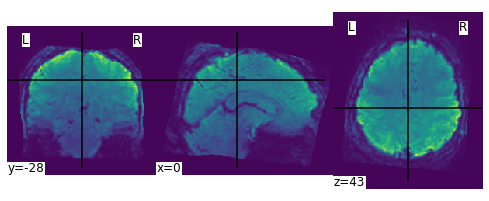

In [26]:
# plotting.plot_img(hdr, bg_img='../sourcedata/templates/mni_icbm152_t1_tal_nlin_asym_09c_brain.nii')


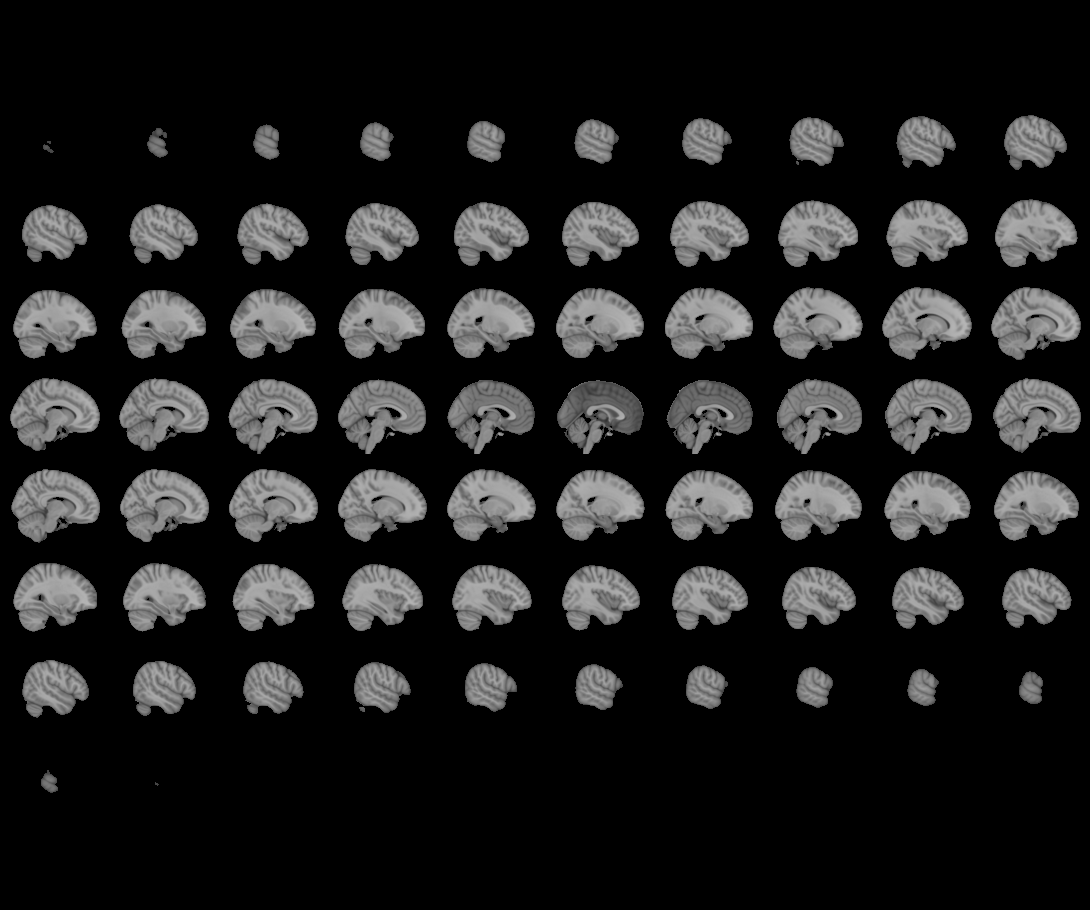
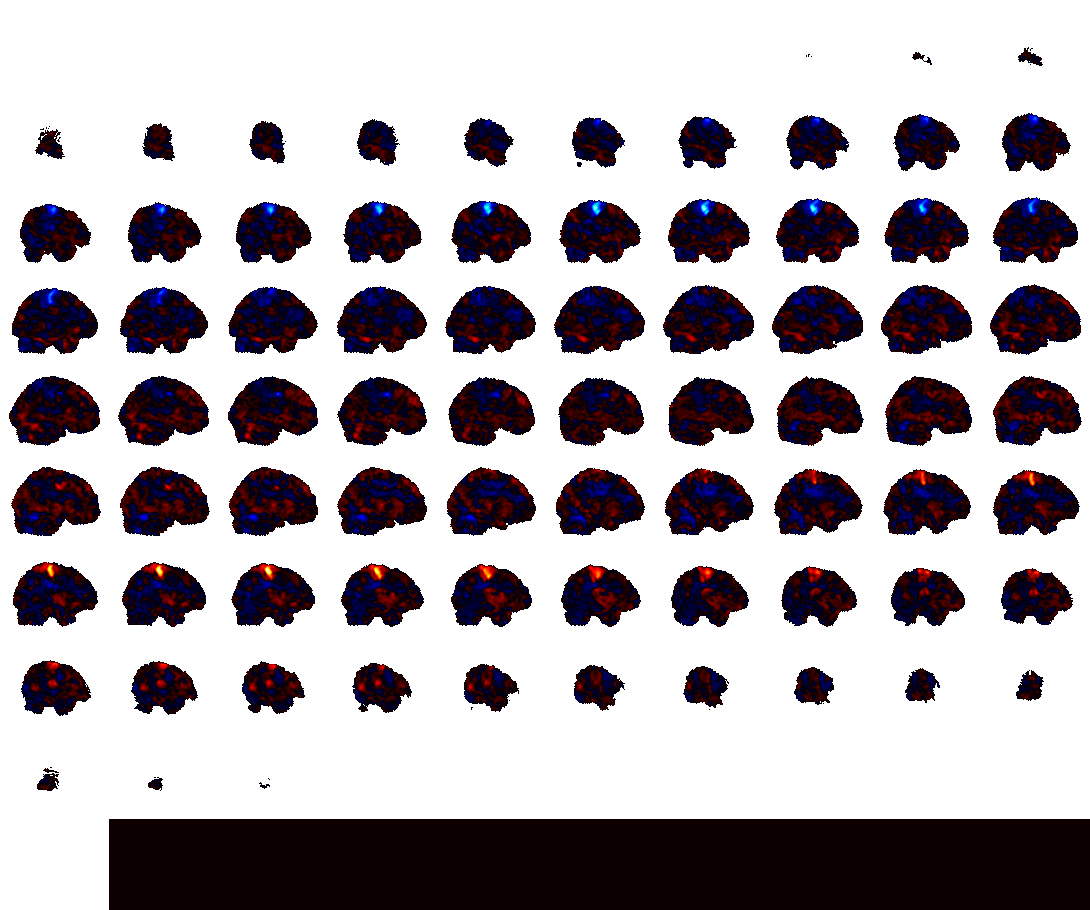

In [13]:
# import nibabel as nib
# import nilearn
# from nilearn import plotting

# img='/home/stevenm/Projects/trondheim/nipype_outputs/second_level_model/sub-002/ses-rlsat/model-0/sub-002_ses-rlsat_task-rlsat_space-MNI152NLin2009cAsym_model-0_contrast-1_desc-zstat.nii.gz'
# plotting.view_img(img)

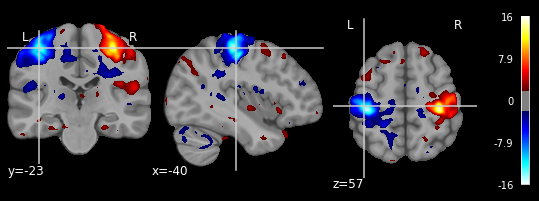

In [14]:
# template_brain = '/home/Public/trondheim/sourcedata/templates/mni_icbm152_t1_tal_nlin_asym_09c_brain.nii'

# plotting.plot_stat_map(img, bg_img=template_brain, threshold=2)

In [45]:
# import nibabel as nib
# import nilearn
# from nilearn import plotting


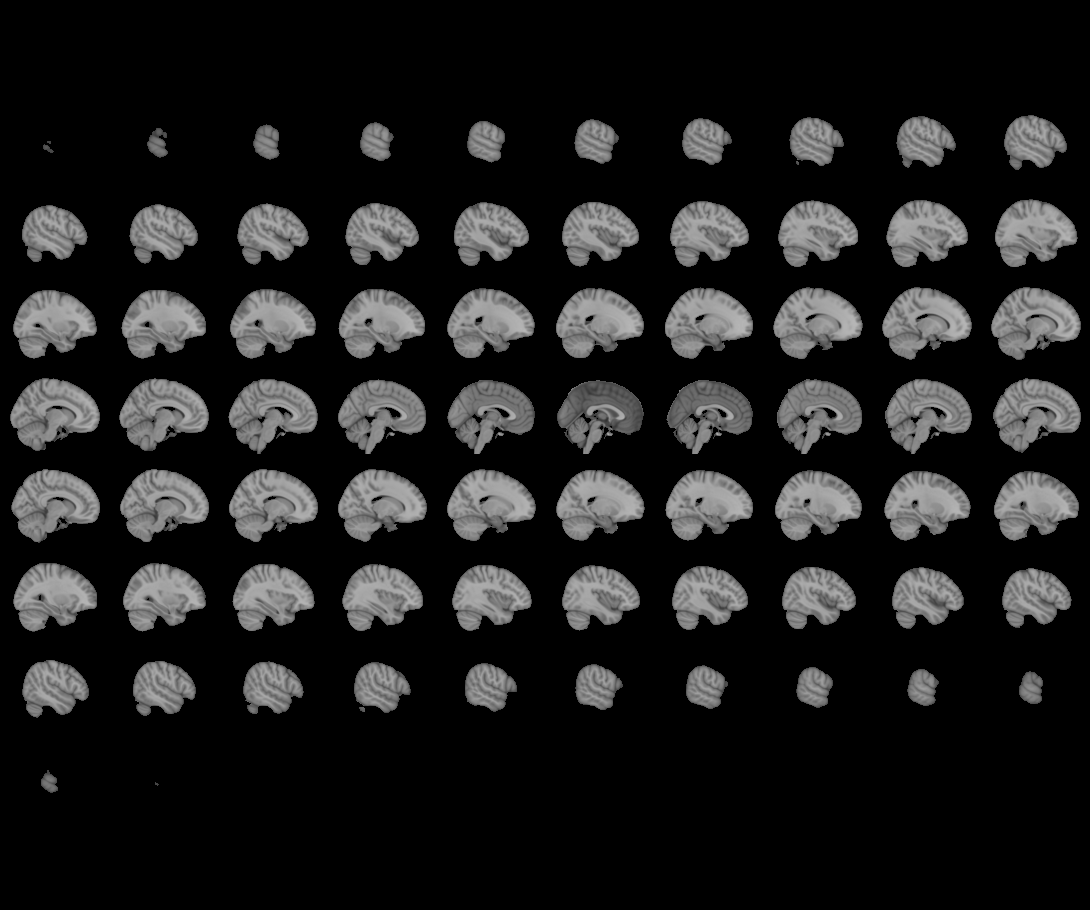
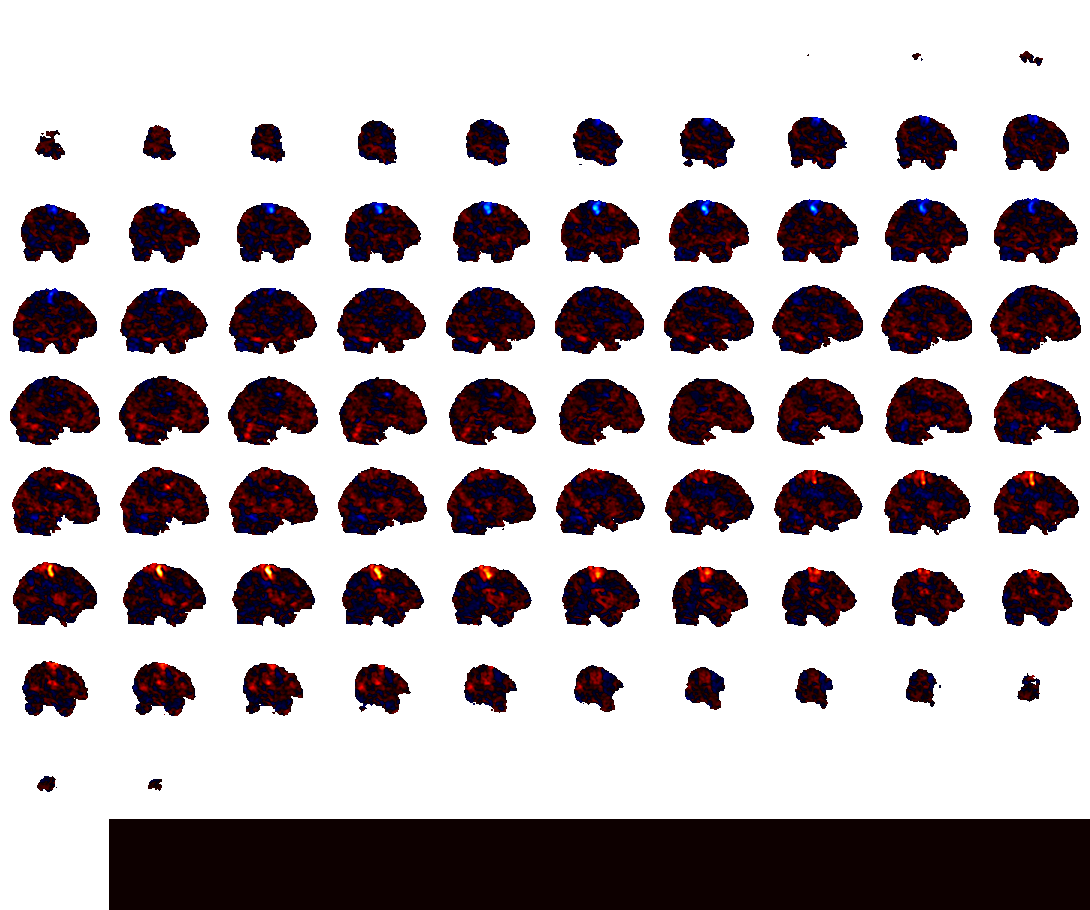

In [28]:
# plotting.view_img('../nipype_outputs/glm_fits_level2/zstats/_subject_id_002/_flameo1/zstat1.nii.gz')


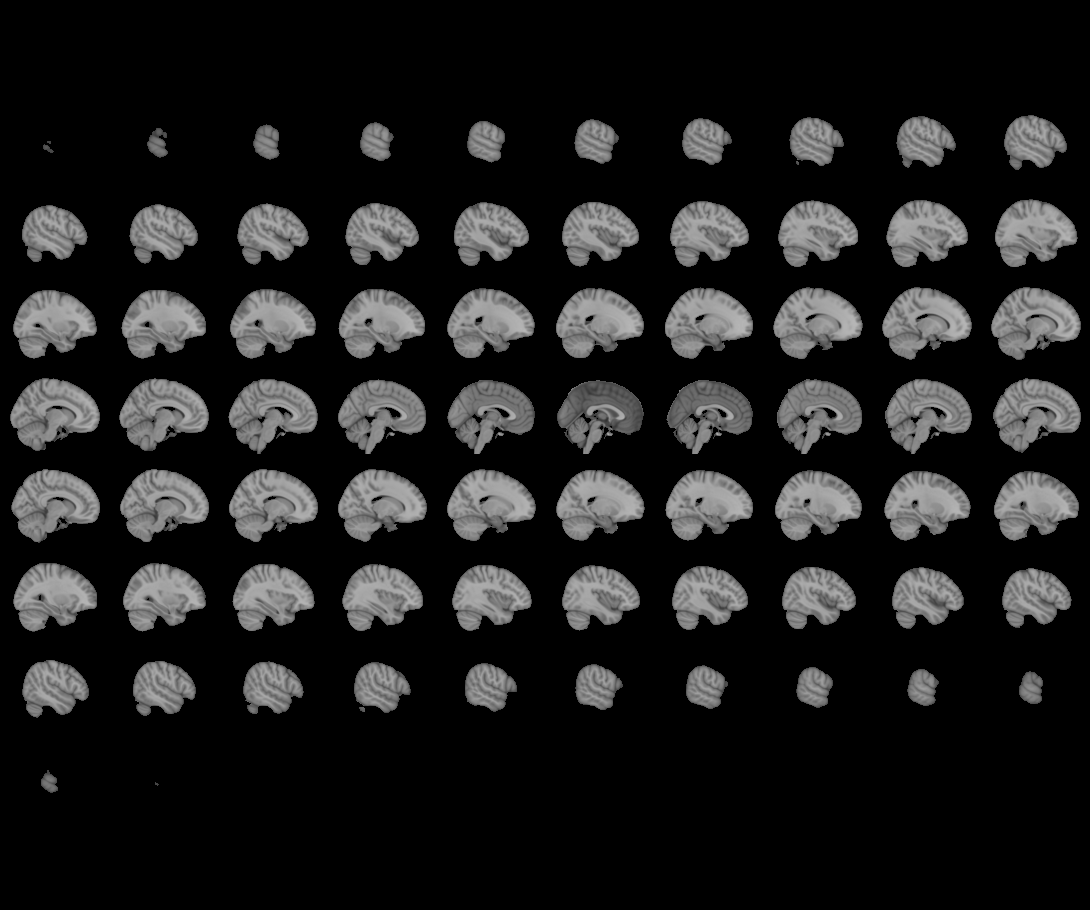
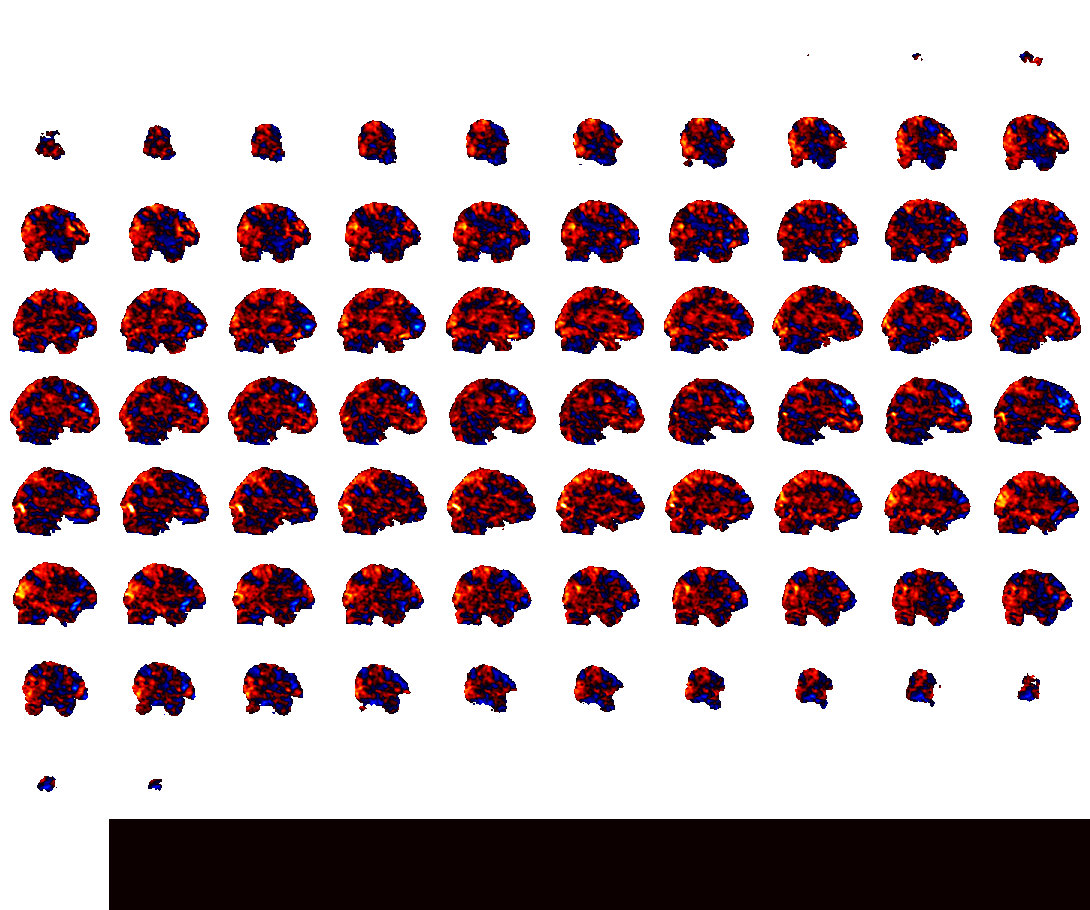

In [34]:
# plotting.view_img('../nipype_outputs/glm_fits_level2/zstats/_subject_id_002/_flameo5/zstat1.nii.gz', vmax=10)

/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/nilearn/plotting/html_document.py:60: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  MAX_IMG_VIEWS_BEFORE_WARNING))



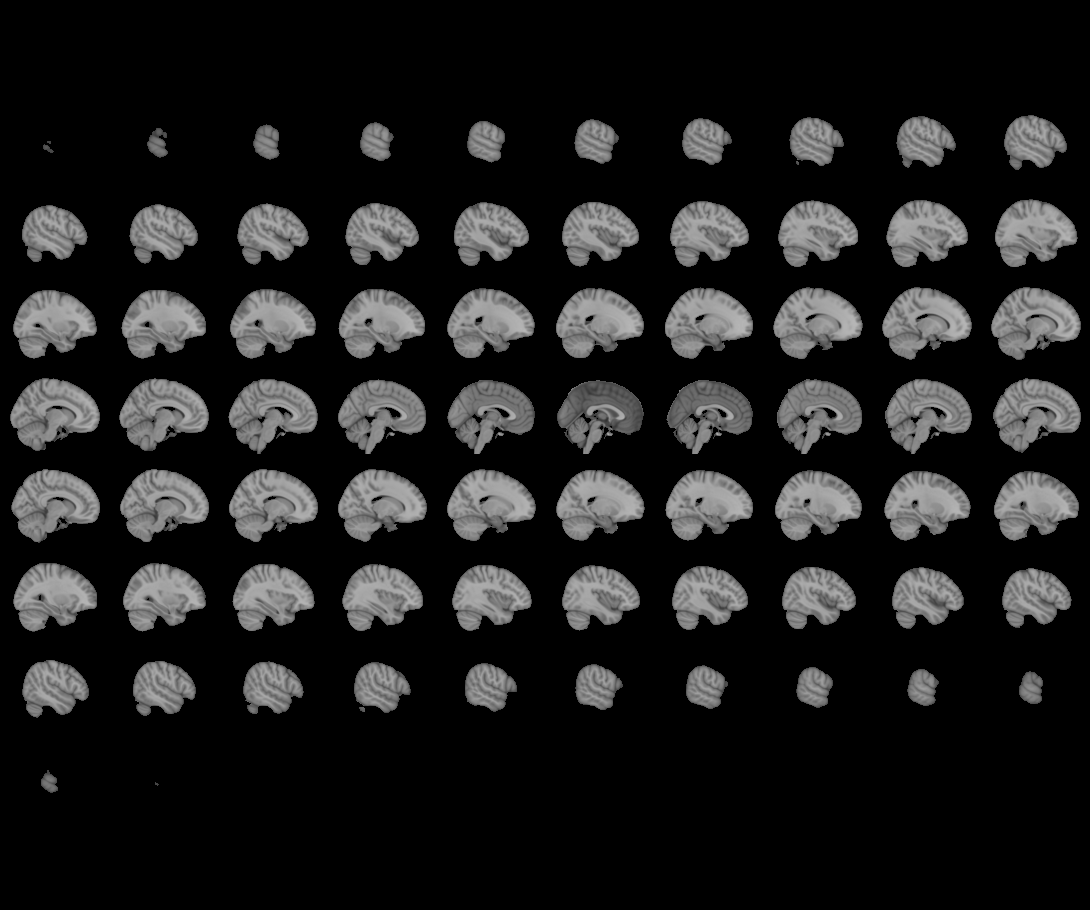
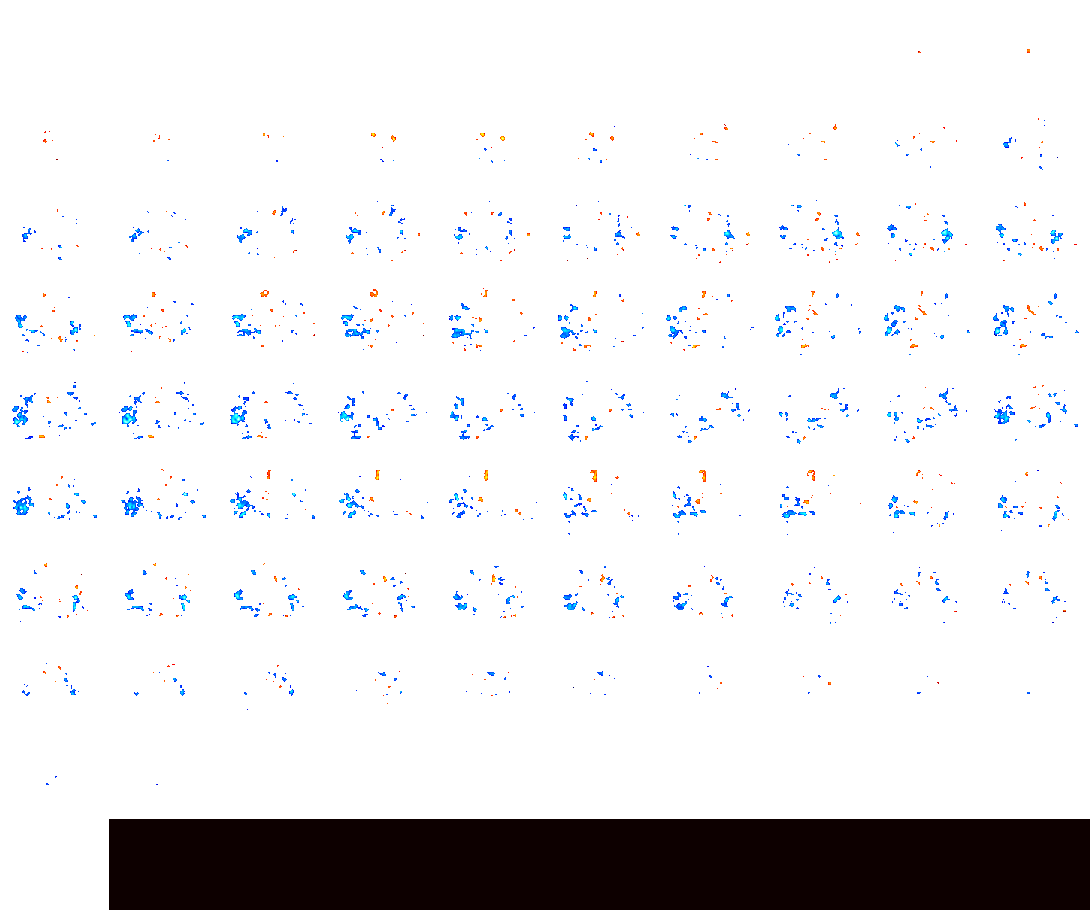

In [38]:
# plotting.view_img('../nipype_outputs/glm_fits_level2/zstats/_subject_id_006/_flameo3/zstat1.nii.gz', threshold=3.1)

/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/nilearn/plotting/html_document.py:60: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  MAX_IMG_VIEWS_BEFORE_WARNING))



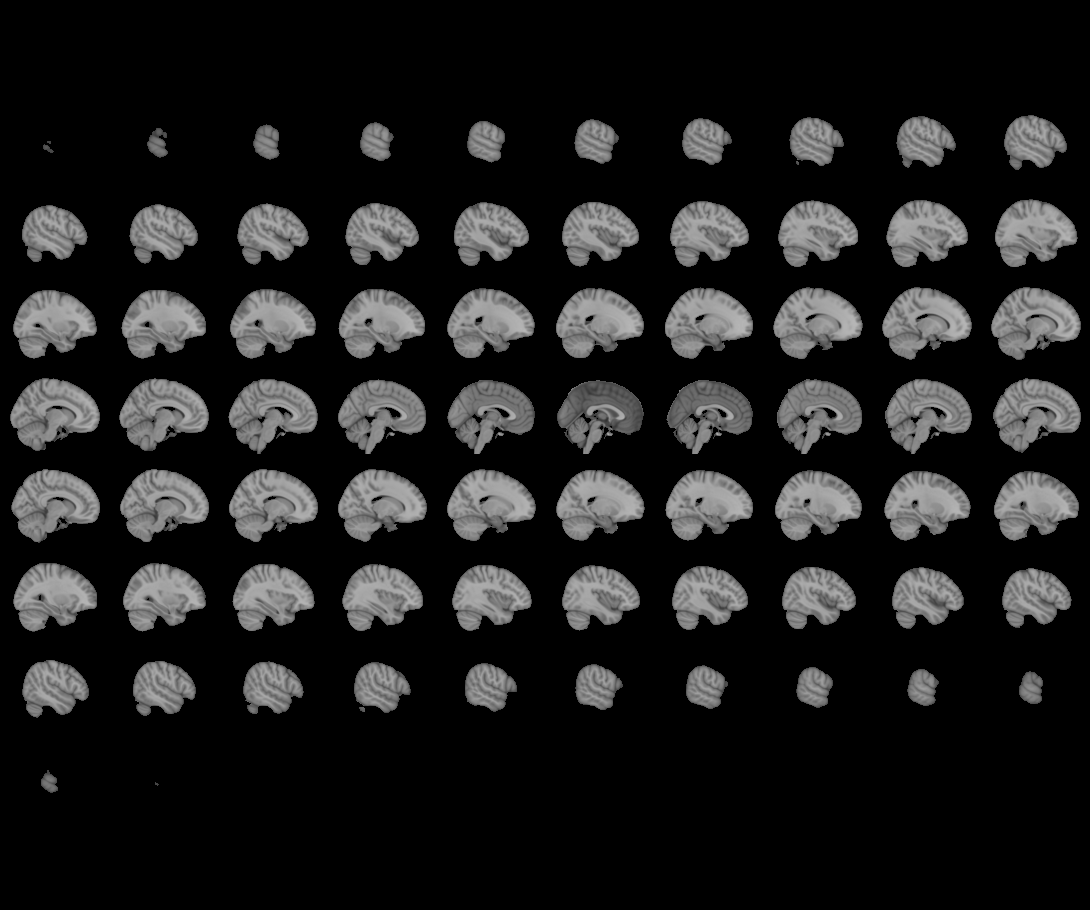
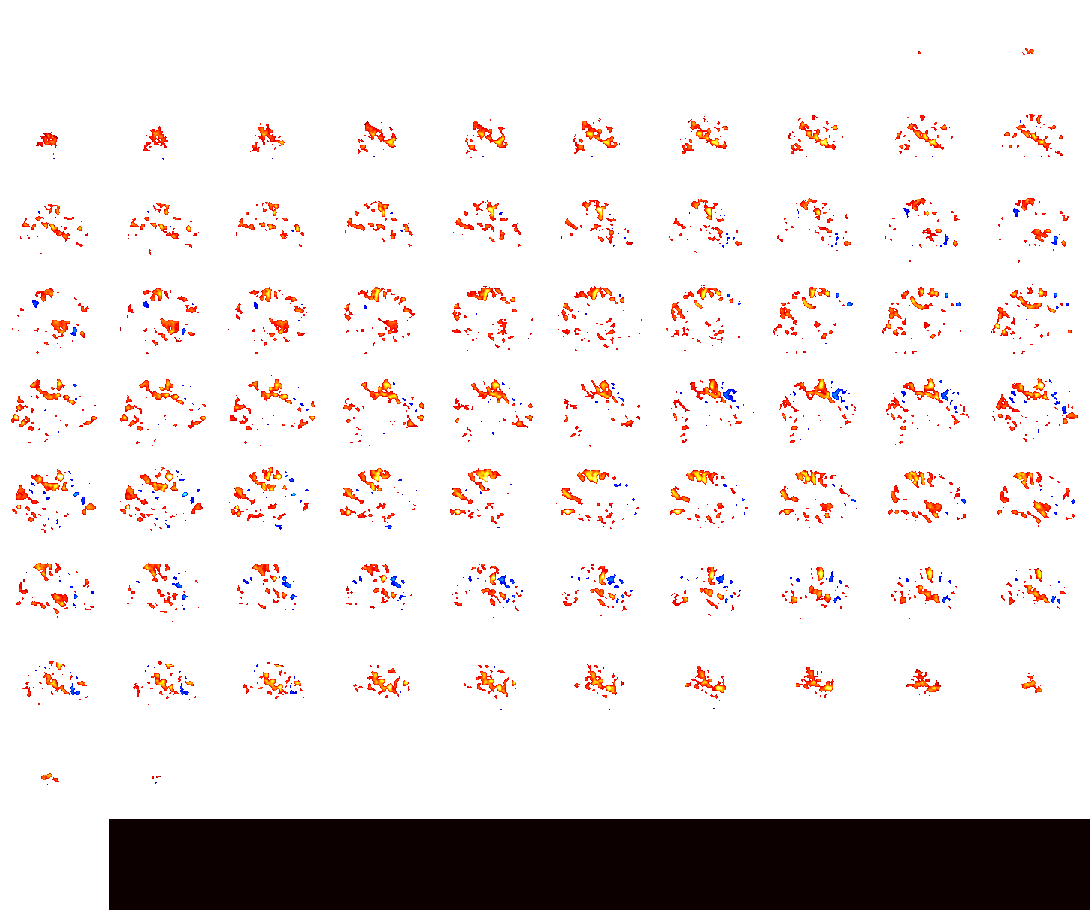

In [39]:

# plotting.view_img('../nipype_outputs/glm_fits_level2/zstats/_subject_id_006/_flameo3/zstat1.nii.gz', vmax=10, threshold=3.1)

/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/nilearn/plotting/html_document.py:60: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  MAX_IMG_VIEWS_BEFORE_WARNING))



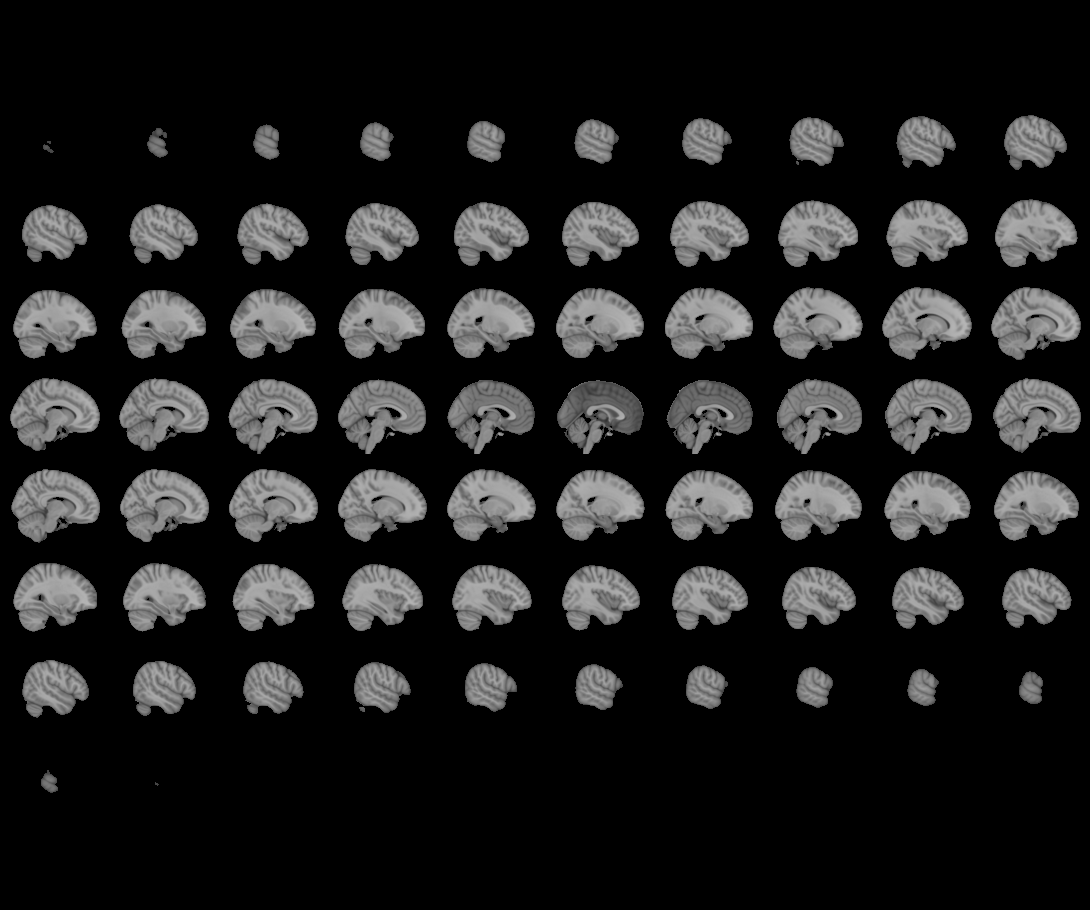
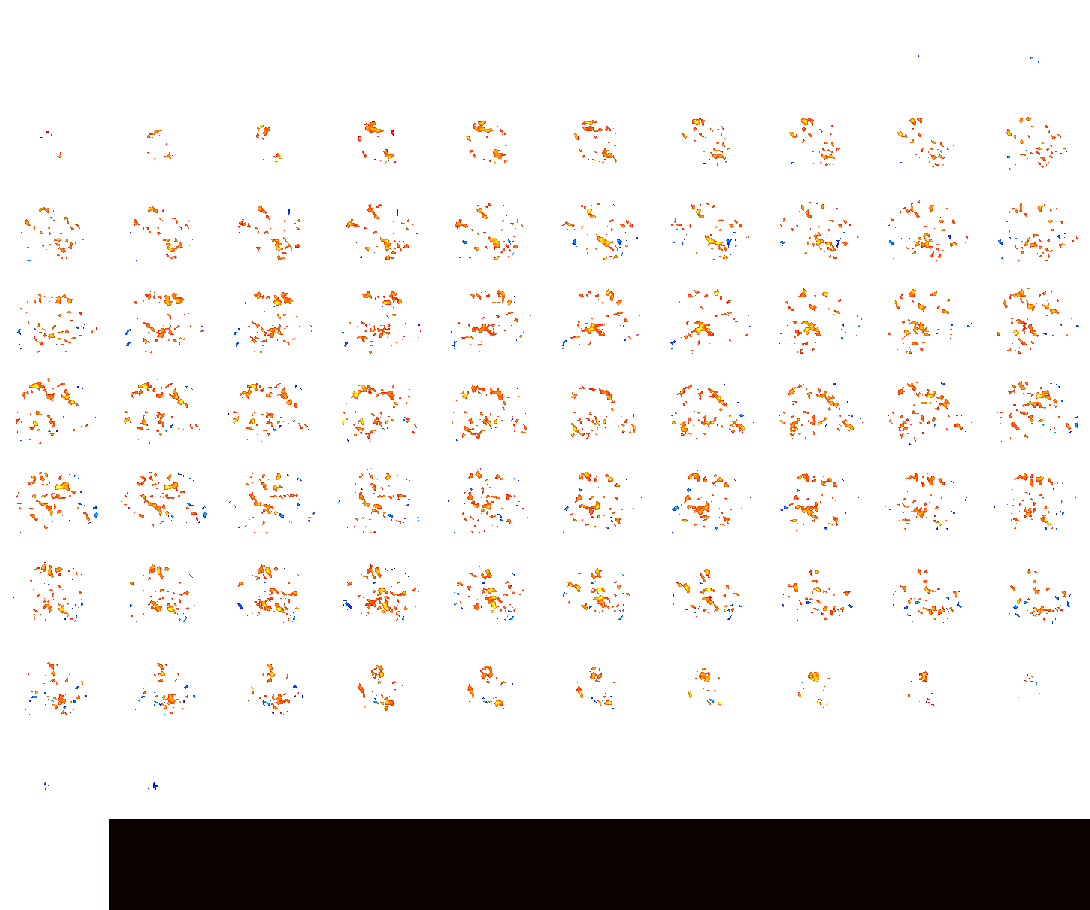

In [43]:
# plotting.view_img('../nipype_outputs/glm_fits_level2/zstats/_subject_id_002/_flameo3/zstat1.nii.gz',threshold=2.3)

## 
$y = \beta X$

$\beta$ = [n_voxels, n_contrasts]

X = [n_contrasts, n_timepoints]

y = [n_voxels, n_timespoints]


Now,
$\beta$ = $\gamma G$

$G$ = [n_gradients, n_contrasts]

$\gamma$ = [n_voxels, n_gradients]


So ideally
$y = (\gamma G) X$

$y = (\beta X)$